In [1]:
import os
import pandas as pd
import requests
import time
import json
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.formula.api as smf
import seaborn as sns 

from sklearn.cross_decomposition import PLSRegression
from pygam import LinearGAM, s
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.stats.multitest import multipletests
from scipy.stats import gaussian_kde


In [2]:
data_folder = os.path.join(os.path.expanduser("~/Desktop/Trading"), "Data")
os.makedirs(data_folder, exist_ok=True)
tickers_csv_file = os.path.join(data_folder, "sp500_tickers.csv")


# THIS pulls sector and subsector info either localy if it's cached or from the api

API_KEY = "YwnbHRjcJvf6Md2OPoKbSRGHlzZ7hjR6"

# --- LOAD FROM CACHE OR FETCH ---
if os.path.exists(tickers_csv_file):
    print("Loading tickers from CSV cache...")
    df_sp500 = pd.read_csv(tickers_csv_file)
else:
    print("Fetching tickers from API...")
    url = f"https://financialmodelingprep.com/api/v3/sp500_constituent?apikey={API_KEY}"
    df_sp500 = pd.DataFrame(requests.get(url).json())

    # Save to CSV
    df_sp500.to_csv(tickers_csv_file, index=False)
    print(f"Saved {len(df_sp500)} tickers to CSV cache.")

    
# --- PREVIEW ---
print(df_sp500.shape)
print(df_sp500.columns)

Loading tickers from CSV cache...
(503, 8)
Index(['symbol', 'name', 'sector', 'subSector', 'headQuarter',
       'dateFirstAdded', 'cik', 'founded'],
      dtype='object')


In [3]:
tickers = df_sp500["symbol"].dropna().unique().tolist()

In [4]:
API_KEY = "YwnbHRjcJvf6Md2OPoKbSRGHlzZ7hjR6"
data_folder = os.path.join(os.path.expanduser("~/Desktop/Trading"), "Data")
os.makedirs(data_folder, exist_ok=True)
tickers_csv_file = os.path.join(data_folder, "sp500_tickers.csv")

# Load tickers
df_sp500 = pd.read_csv(tickers_csv_file)
tickers = df_sp500["symbol"].dropna().unique().tolist()

# Output file
output_file = os.path.join(data_folder, "price_and_earnings.json")

def fetch_price_and_earnings(tickers, output_file):
    if os.path.exists(output_file):
        print(f"Loading from cache: {output_file}")
        return pd.DataFrame(json.load(open(output_file)))


def fetch_price_and_earnings(tickers, output_file):
    if os.path.exists(output_file):
        print(f"Loading from cache: {output_file}")
        return pd.DataFrame(json.load(open(output_file)))

    records = []
    for ticker in tickers:
        try:
            # Get current price
            quote_url = f"https://financialmodelingprep.com/api/v3/quote/{ticker}?apikey={API_KEY}"
            price_data = requests.get(quote_url).json()
            if not price_data:
                continue
            price = price_data[0]["price"]
            price_date = price_data[0].get("date")  # trading date

            # Get latest annual income statement
            income_url = f"https://financialmodelingprep.com/api/v3/income-statement/{ticker}?limit=1&apikey={API_KEY}"
            income_data = requests.get(income_url).json()
            if not income_data:
                continue
            eps = income_data[0].get("eps")
            net_income = income_data[0].get("netIncome")
            report_date = income_data[0].get("date")  # fiscal period end date

            records.append({
                "symbol": ticker,
                "price": price,
                "price_date": price_date,
                "eps": eps,
                "netIncome": net_income,
                "date": report_date
            })

        except Exception as e:
            print(f"Error fetching {ticker}: {e}")
        time.sleep(0.2)  # polite rate limit

    # Save to JSON
    with open(output_file, "w") as f:
        json.dump(records, f, indent=2)
    print(f"Saved {len(records)} records to {output_file}")

    return pd.DataFrame(records)


price_earnings_df = fetch_price_and_earnings(tickers, output_file)
price_earnings_df.columns

Loading from cache: /Users/nicholassanso/Desktop/Trading/Data/price_and_earnings.json


Index(['symbol', 'price', 'price_date', 'eps', 'netIncome', 'date'], dtype='object')

In [5]:
#CLEANS AND TAKES LOG OF THE PE DATA

# Only keep rows with positive EPS
pe_data = price_earnings_df[price_earnings_df["eps"] > 0].copy()

# Compute log(PE)
pe_data["log_PE"] = np.log(pe_data["price"] / pe_data["eps"])

# Print row count for reference
print(pe_data.shape)

(480, 7)


# break

In [6]:
# FETCHES INCOME STATEMENT AND BS STATEMENT AND CF STATEMENT
def fetch_statement(endpoint, tickers, period, limit, data_folder):
    """Fetch statements with unique JSON filename based on endpoint, period, limit."""
    output_file = os.path.join(
        data_folder,
        f"{endpoint}_{period}_limit{limit}.json"
    )

    if os.path.exists(output_file):
        print(f"Loading from cache: {output_file}")
        with open(output_file, "r") as f:
            return json.load(f)

    records = []
    for ticker in tickers:
        url = f"https://financialmodelingprep.com/api/v3/{endpoint}/{ticker}?period={period}&limit={limit}&apikey={API_KEY}"
        try:
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()
            if data:
                for row in data:
                    row["symbol"] = ticker
                records.extend(data)
        except Exception as e:
            print(f"Error fetching {ticker} ({endpoint}): {e}")
        time.sleep(.2)  # API polite rate limit

    with open(output_file, "w") as f:
        json.dump(records, f, indent=2)
    print(f"Saved {len(records)} records to {output_file}")
    # "RECORDS HERE IS A LIST OF STRINGS NOT A DF"
    return records

# AT THIS POINT INCOME_DATA_2_YEARS IS STILL A LIST OF STRINGS STORED AS A VAR
income_data_2_years   = fetch_statement("income-statement", tickers, "annual", 2, data_folder)
balance_data_2_years  = fetch_statement("balance-sheet-statement", tickers, "annual", 2, data_folder)
cashflow_data_2_years = fetch_statement("cash-flow-statement", tickers, "annual", 2, data_folder)

# INCOME_DATA_2_YEARS IS CONVERTED TO A DF
income_data_2_years   = pd.DataFrame(income_data_2_years)
balance_data_2_years  = pd.DataFrame(balance_data_2_years)
cashflow_data_2_years = pd.DataFrame(cashflow_data_2_years)

print("Income shape:", income_data_2_years.shape)
print("Balance shape:", balance_data_2_years.shape)
print("Cash flow shape:", cashflow_data_2_years.shape)

Loading from cache: /Users/nicholassanso/Desktop/Trading/Data/income-statement_annual_limit2.json
Loading from cache: /Users/nicholassanso/Desktop/Trading/Data/balance-sheet-statement_annual_limit2.json
Loading from cache: /Users/nicholassanso/Desktop/Trading/Data/cash-flow-statement_annual_limit2.json
Income shape: (1006, 38)
Balance shape: (1006, 54)
Cash flow shape: (1006, 40)


In [7]:
def sort_by_symbol_then_date(df):
    return df.sort_values(["symbol", "date"])


def compute_yoy_growth(df, exclude_cols=["symbol", "date","link","finalLink"]):
    numeric_cols = df.select_dtypes(include=[float, int]).columns
    numeric_cols = [c for c in numeric_cols if c not in exclude_cols]
    
    df_growth = df.copy()
    for col in numeric_cols:
        df_growth[col + "_yoy"] = df.groupby("symbol")[col].pct_change()
    
    return df_growth

income_sorted = sort_by_symbol_then_date(income_data_2_years)
balance_sorted = sort_by_symbol_then_date(balance_data_2_years)
cashflow_sorted = sort_by_symbol_then_date(cashflow_data_2_years)
pe_data_sorted = sort_by_symbol_then_date(pe_data)

income_growth = compute_yoy_growth(income_sorted)
balance_growth = compute_yoy_growth(balance_sorted)
cashflow_growth = compute_yoy_growth(cashflow_sorted)


#we are sorting to make sure that hte dates are properly aligned before we perform out pct chagne method 

In [8]:
def count_zeros_nans_yoy(df):
    # Keep only numeric columns that end with "_yoy"
    numeric_cols = [c for c in df.select_dtypes(include=[float, int]).columns if c.endswith("_yoy")]
    
    # Count zeros and NaNs
    zero_counts = (df[numeric_cols] == 0).sum()
    nan_counts = df[numeric_cols].isna().sum()
    
    # Combine into a single DataFrame
    summary = pd.DataFrame({
        "zeros": zero_counts,
        "nans": nan_counts
    }).sort_values(by=["zeros", "nans"], ascending=True)
    
    # Force full display
    with pd.option_context("display.max_rows", None, "display.max_columns", None):
        print(summary)
    
    return summary

# Example usage
print("Income 0/NaN counts per YoY column:")
income_summary = count_zeros_nans_yoy(income_growth)

print("\nBalance 0/NaN counts per YoY column:")
balance_summary = count_zeros_nans_yoy(balance_growth)

print("\nCashflow 0/NaN counts per YoY column:")
cashflow_summary = count_zeros_nans_yoy(cashflow_growth)

# the purpose here is to make it easy to identify which line items (columns) are fully filled out from our sample so that we are only grabbing columns (features)
# that are likely to be filled out by the stock under consideration, cause ultimately after we find a regression that has explanatory power... we can still only apply it 
# to the stock under consideration if it has the same line items filled out 
# the 503 nans is a result of the .pct change method that we used which creates a nan on every other row

Income 0/NaN counts per YoY column:
                                             zeros  nans
revenue_yoy                                      0   503
grossProfit_yoy                                  0   503
costAndExpenses_yoy                              0   503
ebitda_yoy                                       0   503
ebitdaratio_yoy                                  0   503
operatingIncome_yoy                              0   503
operatingIncomeRatio_yoy                         0   503
incomeBeforeTax_yoy                              0   503
incomeBeforeTaxRatio_yoy                         0   503
netIncomeRatio_yoy                               0   503
operatingExpenses_yoy                            0   507
costOfRevenue_yoy                                0   510
totalOtherIncomeExpensesNet_yoy                  0   535
generalAndAdministrativeExpenses_yoy             0   751
netIncome_yoy                                    1   503
eps_yoy                                          1  

In [9]:
def remove_single_period_features(df, nan_threshold=503, keep_cols=["symbol","date"], name=""):
    """Select _yoy numeric columns, replace inf, drop rows/columns with too many NaNs."""
    yoy_cols = [c for c in df.select_dtypes(include=[float, int]).columns if c.endswith("_yoy")]
    sub_df = df[yoy_cols + keep_cols].copy()  # Keep symbol/date columns
    
    # Drop columns with too many NaNs (only apply to yoy columns)
    valid_yoy_cols = [c for c in yoy_cols if sub_df[c].isna().sum() <= nan_threshold]
    sub_df = sub_df[valid_yoy_cols + keep_cols]
    
    # Replace infinities with NaN and drop rows with any remaining NaNs (only apply to yoy columns)
    sub_df[valid_yoy_cols] = sub_df[valid_yoy_cols].replace([np.inf, -np.inf], np.nan)
    sub_df.dropna(subset=valid_yoy_cols, inplace=True)
    
    print(f"{name} cleaned shape: {sub_df.shape}")
    return sub_df

# Step 0: Clean _yoy columns and print shapes
income_post_nans = remove_single_period_features(income_growth, name="Income")
balance_post_nans = remove_single_period_features(balance_growth, name="Balance")
cashflow_post_nans = remove_single_period_features(cashflow_growth, name="Cashflow")


Income cleaned shape: (503, 18)
Balance cleaned shape: (503, 11)
Cashflow cleaned shape: (501, 12)


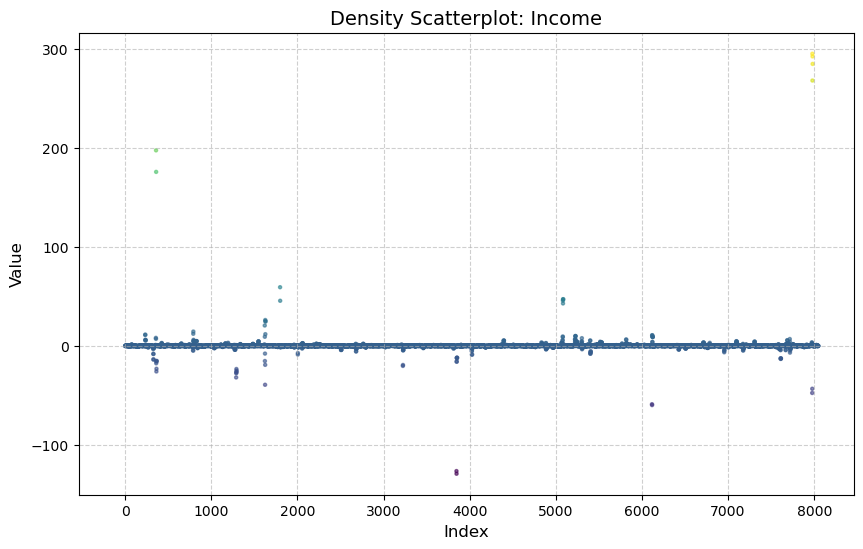

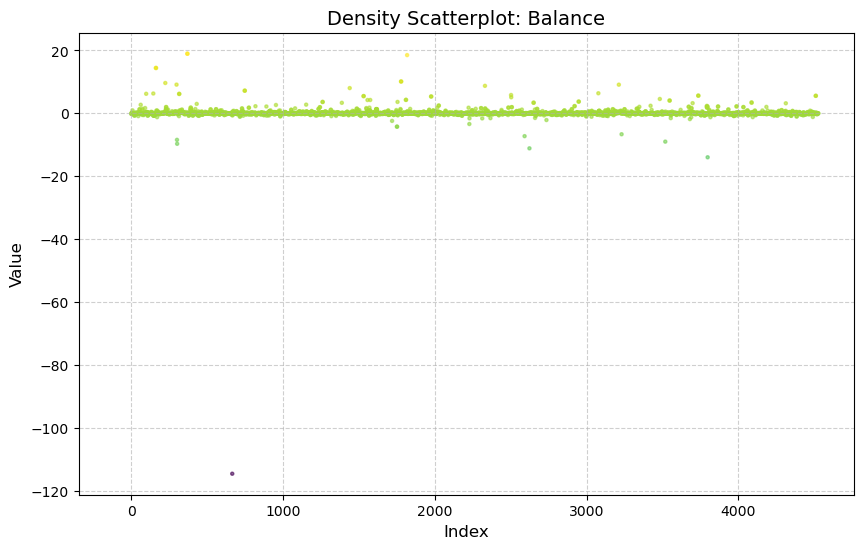

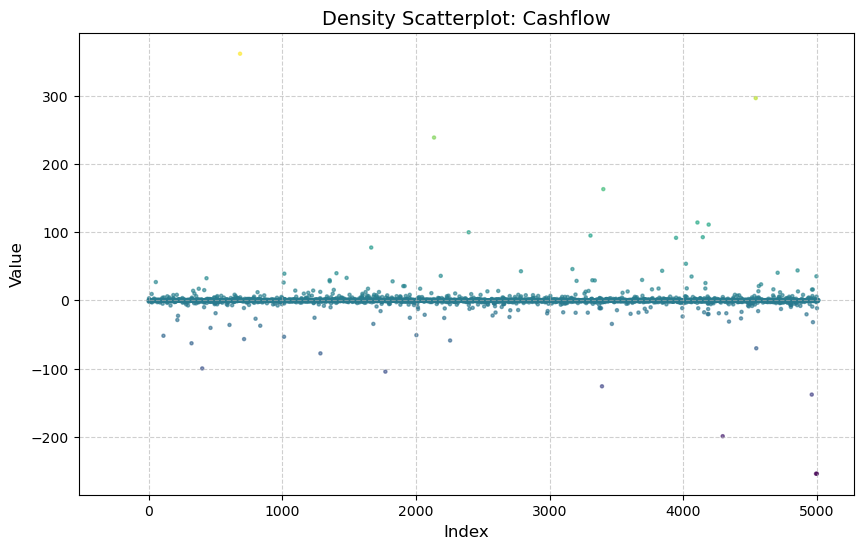

In [10]:
def plot_density_scatter(df, title):
    # Flatten all numeric columns into one long vector
    numeric_cols = df.select_dtypes(include=["float", "int"]).columns
    values = df[numeric_cols].values.flatten()
    values = values[~np.isnan(values)]  # drop NaNs

    # Scatter vs. index, colored by density
    plt.figure(figsize=(10, 6))
    sns.kdeplot(values, fill=True, color="lightblue", alpha=0.3, linewidth=0)  # background density
    plt.scatter(range(len(values)), values, 
                c=values, cmap="viridis", s=5, alpha=0.6)

    plt.title(f"Density Scatterplot: {title}", fontsize=14)
    plt.xlabel("Index", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

# Call for each of your cleaned DataFrames
plot_density_scatter(income_post_nans, "Income")
plot_density_scatter(balance_post_nans, "Balance")
plot_density_scatter(cashflow_post_nans, "Cashflow")

#demonstrates the necessity for addressing outlier concerns 

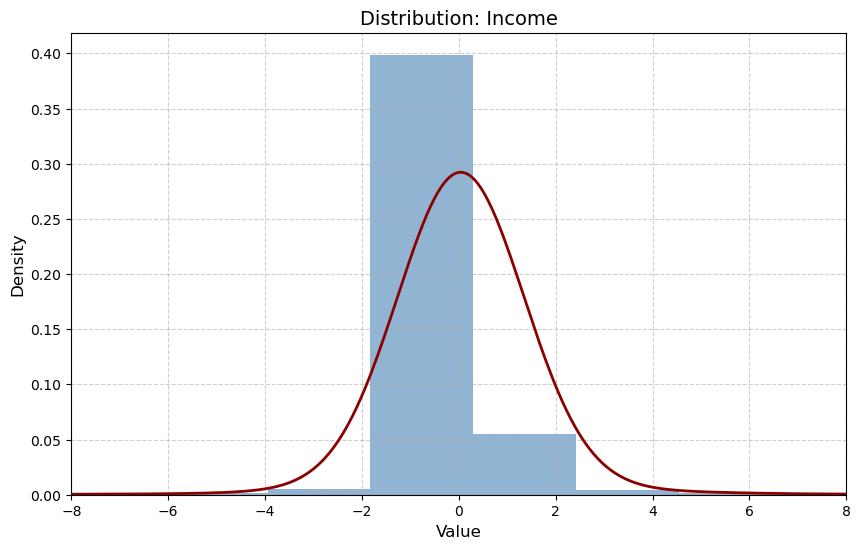

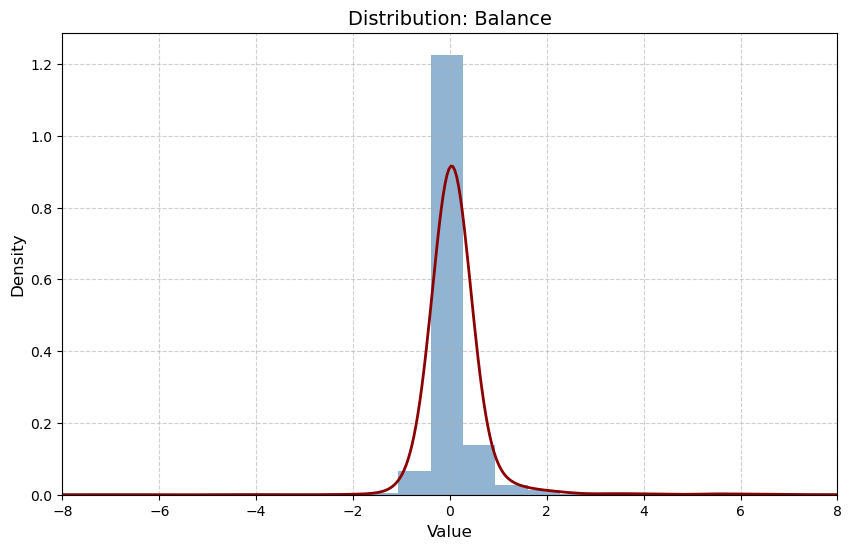

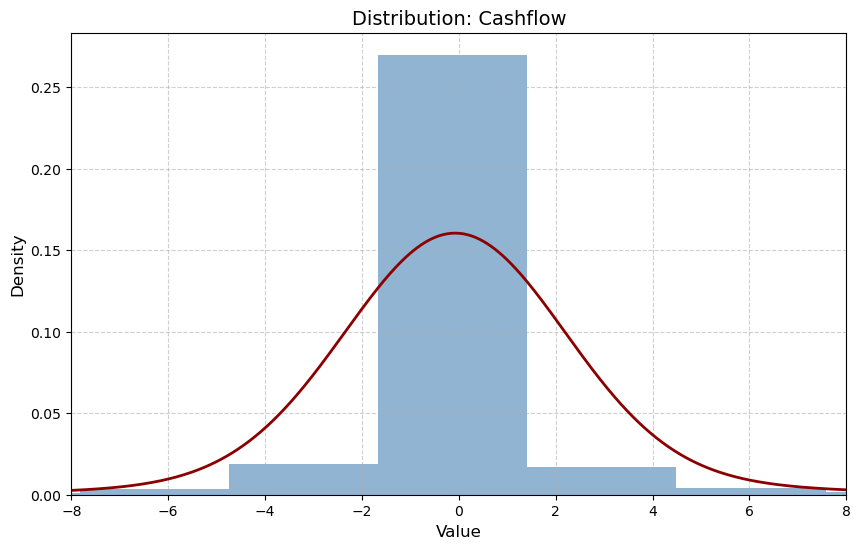

In [11]:
def plot_distribution(df, title):
    # Flatten numeric columns into one vector
    numeric_cols = df.select_dtypes(include=["float", "int"]).columns
    values = df[numeric_cols].values.flatten()
    values = values[~np.isnan(values)]  # remove NaNs

    plt.figure(figsize=(10, 6))
    plt.hist(values, bins=200, density=True, alpha=0.6, color="steelblue")
    
    # KDE overlay
    kde = gaussian_kde(values)
    xs = np.linspace(-8, 8, 400)
    plt.plot(xs, kde(xs), color="darkred", lw=2)

    plt.title(f"Distribution: {title}", fontsize=14)
    plt.xlabel("Value", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.xlim(-8, 8)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

# Call for each dataset
plot_distribution(income_post_nans, "Income")
plot_distribution(balance_post_nans, "Balance")
plot_distribution(cashflow_post_nans, "Cashflow")


In [12]:
# Step 1: Keep only common (symbol, date) pairs
for df in [income_post_nans, balance_post_nans, cashflow_post_nans,pe_data]:
    df["symbol_date"] = list(zip(df["symbol"], df["date"]))

In [13]:
common_pairs = (
    set(income_post_nans["symbol_date"])
    & set(balance_post_nans["symbol_date"])
    & set(cashflow_post_nans["symbol_date"])
    & set(pe_data["symbol_date"])
)

def filter_by_common_pairs(df, common_pairs):
    """
    Keep only rows where the 'symbol_date' is in common_pairs.
    Returns a new DataFrame.
    """
    return df[df["symbol_date"].isin(common_pairs)].copy()

income_post_nans_overlapped = filter_by_common_pairs(income_post_nans, common_pairs)
balance_post_nans_overlapped = filter_by_common_pairs(balance_post_nans, common_pairs)
cashflow_post_nans_overlapped = filter_by_common_pairs(cashflow_post_nans, common_pairs)
pe_post_nans_overlapped = filter_by_common_pairs(pe_data, common_pairs)

# we only want to include a ticker if we have all the financial statement items for all dataframes

In [14]:
# Step 2: Sort consistently
income_post_nans_overlapped = income_post_nans_overlapped.sort_values(["symbol", "date"]).reset_index(drop=True)
balance_post_nans_overlapped = balance_post_nans_overlapped.sort_values(["symbol", "date"]).reset_index(drop=True)
cashflow_post_nans_overlapped = cashflow_post_nans_overlapped.sort_values(["symbol", "date"]).reset_index(drop=True)
pe_post_nans_overlapped = pe_post_nans_overlapped.sort_values(["symbol", "date"]).reset_index(drop=True)


print(
    "Cleaned and aligned shapes:", 
    income_post_nans_overlapped.shape,   
    pe_post_nans_overlapped.shape,
    balance_post_nans_overlapped.shape, 
    cashflow_post_nans_overlapped.shape
)

Cleaned and aligned shapes: (477, 19) (477, 8) (477, 12) (477, 13)


In [15]:
def check_alignment(dfs: dict):
    """
    Check alignment of multiple DataFrames on 'symbol' and 'date'.
    Expects each DataFrame to have the same row order and columns: 'symbol', 'date'.
    
    Parameters
    
    None (prints summary of mismatches)
    """
    # Ensure equal lengths
    lengths = {name: len(df) for name, df in dfs.items()}
    if len(set(lengths.values())) > 1:
        print("⚠️ Row counts differ between DataFrames:")
        for name, length in lengths.items():
            print(f"  {name}: {length} rows")
    else:
        print(f"✅ All DataFrames have {list(lengths.values())[0]} rows")

    # Concatenate for comparison
    merged = pd.concat(
        {name: df[["symbol", "date"]].reset_index(drop=True) for name, df in dfs.items()},
        axis=1
    )

    # Compare across DataFrames
    base = list(dfs.keys())[0]  # pick first as reference
    symbol_mismatches = 0
    date_mismatches = 0

    for i in range(len(dfs[base])):
        symbols = [merged[(name, "symbol")][i] for name in dfs.keys()]
        dates   = [merged[(name, "date")][i]   for name in dfs.keys()]
        if len(set(symbols)) > 1:
            symbol_mismatches += 1
        if len(set(dates)) > 1:
            date_mismatches += 1

    print(f"Symbol mismatches: {symbol_mismatches}")
    print(f"Date mismatches:   {date_mismatches}")


In [16]:
check_alignment({
    "income": income_post_nans_overlapped,
    "balance": balance_post_nans_overlapped,
    "cashflow": cashflow_post_nans_overlapped,
    "pe": pe_post_nans_overlapped
})

✅ All DataFrames have 477 rows
Symbol mismatches: 0
Date mismatches:   0


In [17]:
def run_univariate_regressions(X, y):

    # --- Drop duplicate columns by name ---
    X = X.loc[:, ~X.columns.duplicated()].copy()

    results = []

    for col in X.columns:
        X_const = sm.add_constant(X[[col]])
        model = sm.OLS(y, X_const).fit()
        coef = model.params[col]
        t_value = model.tvalues[col]
        pval = model.pvalues[col]
        r2 = model.rsquared
        results.append((col, coef, t_value, pval, r2))

    results_df = pd.DataFrame(
        results, columns=["feature", "coef", "t_value", "pval", "r2"]
    )

    # Apply Benjamini-Hochberg FDR correction
    reject, pvals_corrected, _, _ = multipletests(
        results_df["pval"], alpha=0.1, method="fdr_bh"
    )
    results_df["pval_fdr"] = pvals_corrected
    results_df["reject_null"] = reject

    return results_df


In [18]:
def run_statement_univariate(statement_df, log_pe_df, label=""):

    merged = statement_df.merge(log_pe_df, on="symbol", how="inner")
    X = merged.select_dtypes(include=["number"]).drop(columns=["log_PE"])
    y = merged["log_PE"]

    uni_results = run_univariate_regressions(X, y)

    return merged, uni_results


In [19]:
# 1. Prepare the dependent variable (only symbol + log_PE, no date)
log_pe_df = pe_post_nans_overlapped[["symbol", "log_PE"]].copy()

income_merged, income_univariate = run_statement_univariate(income_post_nans_overlapped, log_pe_df, label="income")
balance_merged, balance_univariate = run_statement_univariate(balance_post_nans_overlapped, log_pe_df, label="balance")
cashflow_merged, cashflow_univariate = run_statement_univariate(cashflow_post_nans_overlapped, log_pe_df, label="cashflow")

print(income_merged.shape, balance_merged.shape, cashflow_merged.shape)

print(income_univariate.columns)

(477, 20) (477, 13) (477, 14)
Index(['feature', 'coef', 't_value', 'pval', 'r2', 'pval_fdr', 'reject_null'], dtype='object')


/var/folders/3v/cffbrkr510z708th2gtn8s600000gn/T/ipykernel_41636/2339470113.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='R²')


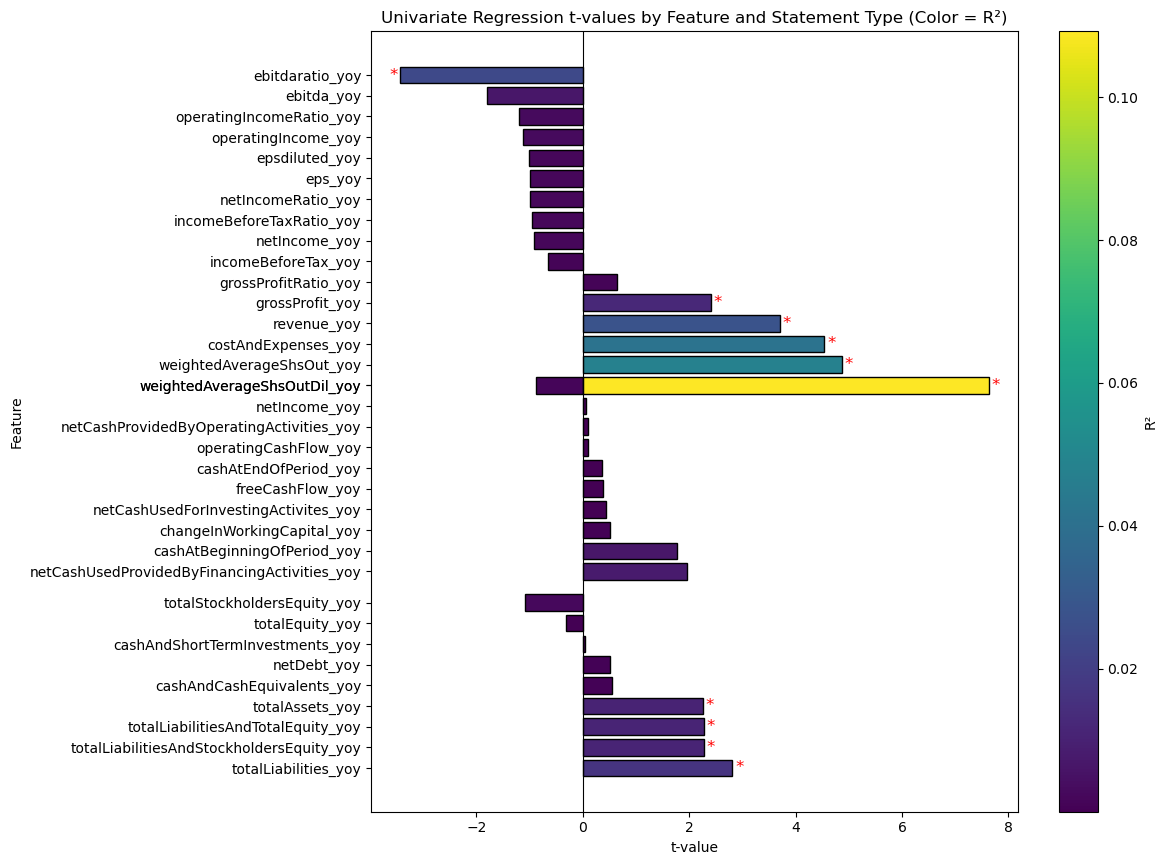

In [20]:
# 1. Combine the three DataFrames temporarily for plotting
plot_df = pd.concat([
    income_univariate.assign(statement_type='Income'),
    balance_univariate.assign(statement_type='Balance'),
    cashflow_univariate.assign(statement_type='Cashflow')
], ignore_index=True)

# 2. Sort within each statement by absolute t-value descending
plot_df = plot_df.sort_values(['statement_type', 't_value'], ascending=[True, False]).reset_index(drop=True)

# 3. Normalize r2 for color mapping
norm = mpl.colors.Normalize(vmin=plot_df['r2'].min(), vmax=plot_df['r2'].max())
cmap = mpl.cm.viridis
colors = [cmap(norm(val)) for val in plot_df['r2']]

# 4. Prepare the y positions for grouping by statement
statement_order = ['Income', 'Balance', 'Cashflow']
plot_df['group_num'] = plot_df['statement_type'].map({s: i for i, s in enumerate(statement_order)})

# Add a small offset between groups
group_offsets = plot_df['group_num'] * 0.5
y_pos = range(len(plot_df))
y_pos = [i + offset for i, offset in zip(y_pos, group_offsets)]

# 5. Create horizontal bar chart
plt.figure(figsize=(12, max(8, len(plot_df) * 0.25)))
bars = plt.barh(
    y=y_pos,
    width=plot_df['t_value'],
    color=colors,
    edgecolor='black'
)

# 6. Highlight significant features with a red star
for idx, row in enumerate(plot_df.itertuples()):
    if row.reject_null:
        plt.text(
            x=row.t_value + (0.05 if row.t_value>0 else -0.05),
            y=y_pos[idx],
            s='*',
            va='center',
            ha='left' if row.t_value>0 else 'right',
            color='red',
            fontsize=12
        )

# 7. Y-axis labels
plt.yticks(y_pos, plot_df['feature'])
plt.axvline(0, color='black', linewidth=0.8)
plt.xlabel('t-value')
plt.ylabel('Feature')
plt.title('Univariate Regression t-values by Feature and Statement Type (Color = R²)')

# 8. Add colorbar for R²
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='R²')

plt.tight_layout()
plt.show()


In [21]:
def select_significant_features(univariate_results, merged_df, 
                                t_threshold=1.5, r2_threshold=0.01, p_threshold=0.1, 
                                label=""):
    """
    Select significant features from univariate regression results 
    and return the corresponding data from the merged dataframe.
    """
    total_features = len(univariate_results)

    # Filter by thresholds
    signif = univariate_results[
        (univariate_results["t_value"].abs() > t_threshold) &
        (univariate_results["r2"] > r2_threshold) &
        (univariate_results["pval"] < p_threshold)
    ]

    features = signif["feature"].tolist()
    selected = merged_df[["symbol", "log_PE"] + features]

    if label:
        n_selected = len(features)
        pct = (n_selected / total_features * 100) if total_features > 0 else 0
        print(f"{label.title()}: {n_selected}/{total_features} features selected ({pct:.1f}%)")

    return signif, selected


In [22]:
signif_income, income_selected = select_significant_features(income_univariate, income_merged, label="income")

signif_balance, balance_selected = select_significant_features(balance_univariate, balance_merged, label="balance")

signif_cashflow, cashflow_selected = select_significant_features(cashflow_univariate, cashflow_merged, label="cashflow")


Income: 6/16 features selected (37.5%)
Balance: 4/9 features selected (44.4%)
Cashflow: 0/10 features selected (0.0%)


In [ ]:
# need a line of code here to grab the column names from the "univariate" dataframes and hten go back tot he merged dataframes and grab the actual
# data because that data is what we will run the pca.. the univeriate regresisons are just a filter 

In [ ]:
def run_pca_with_prefix(df, n_components=None, prefix="", columns=None):
    """
    Run PCA on a DataFrame with optional column selection.

    Parameters
    ----------
    df : pd.DataFrame
        Input data.
    n_components : int or None
        Number of PCA components. If None, use all available features.
    prefix : str
        Prefix for the PCA component column names.
    columns : list of str or None
        Subset of columns to run PCA on. If None, use all numeric columns
        except common ID columns like symbol/date.

    Returns
    -------
    pd.DataFrame
        DataFrame with PCA component columns added.
    PCA
        The fitted PCA object.
    """

    # Drop common ID columns if present
    exclude_cols = ["symbol", "date", "symbol_date"]

    if columns is None:
        feature_df = df.drop(columns=[c for c in exclude_cols if c in df.columns], errors="ignore")
    else:
        feature_df = df[columns]

    # Make sure it's numeric
    feature_df = feature_df.select_dtypes(include="number")

    # Handle n_components safely
    max_components = min(feature_df.shape[0], feature_df.shape[1])
    if n_components is None:
        n_components = max_components
    else:
        n_components = min(n_components, max_components)

    # Standardize
    scaler = StandardScaler()
    scaled = scaler.fit_transform(feature_df)

    # PCA
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(scaled)

    comp_df = pd.DataFrame(
        components,
        columns=[f"{prefix}{i+1}" for i in range(components.shape[1])],
        index=df.index
    )

    return pd.concat([df, comp_df], axis=1), pca


In [ ]:
# Income statement PCA
income_df_with_pca, income_pca_model = run_pca_with_prefix(
    income_post_nans_overlapped.drop(columns=["symbol", "date", "symbol_date"], errors="ignore"),
    n_components=3,
    prefix="income_"
)

# Balance sheet PCA
balance_df_with_pca, balance_pca_model = run_pca_with_prefix(
    balance_post_nans_overlapped.drop(columns=["symbol", "date", "symbol_date"], errors="ignore"),
    n_components=3,
    prefix="balance_"
)

# Cash flow PCA
cashflow_df_with_pca, cashflow_pca_model = run_pca_with_prefix(
    cashflow_post_nans_overlapped.drop(columns=["symbol", "date", "symbol_date"], errors="ignore"),
    n_components=3,
    prefix="cashflow_"
)


In [ ]:
def regress_log_pe_on_pca(pca_df, log_pe_df, prefix="income_"):
    """
    Merge PCA outputs with log(PE) and run regression.
    
    Parameters
    ----------
    pca_df : pd.DataFrame
        DataFrame with PCA components (from run_pca_with_prefix).
    log_pe_df : pd.DataFrame
        DataFrame containing ['symbol','date','log_pe'] at least.
    prefix : str
        Prefix used in PCA component names (e.g., 'income_', 'balance_', 'cashflow_').

    Returns
    -------
    statsmodels RegressionResults
        The fitted regression model.
    """

    # 2. Select PCA columns
    X = merged[[c for c in merged.columns if c.startswith(prefix)]]
    y = merged["log_pe"]

    # 3. Add intercept
    X = sm.add_constant(X)

    # 4. Run regression
    model = sm.OLS(y, X).fit()

    print(model.summary())
    return model
